In [1]:
import numpy as np, cv2
from Common.fft2d import FFT, IFFT, calc_spectrum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D             # 3차원 그래프 라이브러리

In [2]:
def get_gaussianFilter(shape, R):
    u = np.array(shape)//2
    y = np.arange(-u[0], u[0], 1)
    x = np.arange(-u[1], u[1], 1)
    x, y = np.meshgrid(x, y)
    filter = np.exp(-(x**2 + y**2)/ (2 * R**2))
    return x, y, filter if len(shape) < 3 else cv2.merge([filter, filter])

In [3]:
def get_gaussianFilter1(shape, sigmaX, sigmaY):           # OpenCV 함수로 가우시안 커널 생성
    r = cv2.getGaussianKernel(shape[0], sigmaY)
    c = cv2.getGaussianKernel(shape[1], sigmaX)
    filter = np.outer(r,c)
    cv2.normalize(filter, filter, 0, 1, cv2.NORM_MINMAX)
    return filter if len(shape) < 3 else cv2.merge([filter, filter])

In [4]:
def get_butterworthFilter(shape, R, n):
    u = np.array(shape)//2
    y = np.arange(-u[0], u[0], 1)
    x = np.arange(-u[1], u[1], 1)
    x, y = np.meshgrid(x, y)
    dist = np.sqrt(x** 2 + y** 2)
    filter = 1 / (1 + np.power(dist / R, 2 * n))
    return x, y, filter if len(shape) < 3 else cv2.merge([filter, filter])

In [5]:
image = cv2.imread('images/filter.jpg', cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 에러")

In [6]:
mode = 3
dft, spectrum = FFT(image, mode)                    # FFT 수행 및 셔플링
x1, y1, gauss_filter = get_gaussianFilter(dft.shape, 30)       # 필터 생성
x2, y2, butter_filter = get_butterworthFilter(dft.shape, 30, 10)

In [7]:
filtered_dft1 = dft * gauss_filter                  # 주파수 공간 필터링 - 원소 간 곱셈
filtered_dft2 = dft * butter_filter
gauss_img = IFFT(filtered_dft1, image.shape, mode)
butter_img= IFFT(filtered_dft2, image.shape, mode)
spectrum1 = calc_spectrum(filtered_dft1)
spectrum2 = calc_spectrum(filtered_dft2)

In [8]:
if mode==3:
    gauss_filter, butter_filter = gauss_filter[:,:,0], butter_filter[:,:,0]

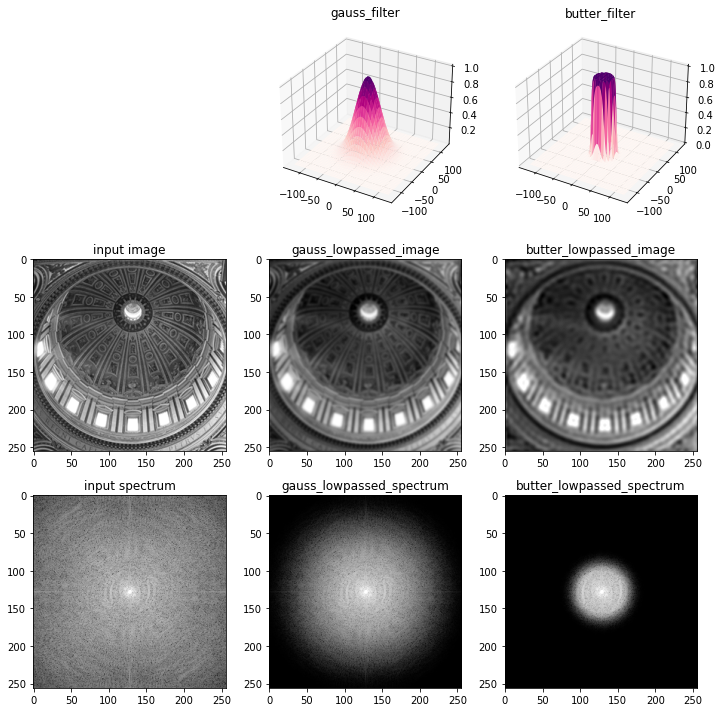

(None, None)

In [11]:
fig = plt.figure(figsize=(10,10))                   # 그래프3 생성
ax1 = plt.subplot(332, projection='3d')
ax1.plot_surface(x1, y1, gauss_filter, cmap='RdPu'), plt.title('gauss_filter')
ax2 = plt.subplot(333, projection='3d')
ax2.plot_surface(x2, y2, butter_filter,cmap='RdPu'), plt.title('butter_filter')
titles = ['input image','gauss_lowpassed_image', 'butter_lowpassed_image',
          'input spectrum','gauss_lowpassed_spectrum','butter_lowpassed_spectrum']
images = [image, gauss_img, butter_img, spectrum, spectrum1, spectrum2]
plt.gray()                                          # 명암도 영상으로 표시
for i, t in enumerate(titles):
    plt.subplot(3,3,i+4), plt.imshow(images[i]), plt.title(t)
plt.tight_layout(), plt.show()